In [1]:
import os
from collections import Counter
try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET
import numpy as np
from scipy import sparse

import util
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be remo

In [2]:
def extract_feats(ffs, direc="train", global_feat_dict=None):
    """
    arguments:
      ffs are a list of feature-functions.
      direc is a directory containing xml files (expected to be train or test).
      global_feat_dict is a dictionary mapping feature_names to column-numbers; it
      should only be provided when extracting features from test data, so that
      the columns of the test matrix align correctly.

    returns:
      a sparse design matrix, a dict mapping features to column-numbers,
      a vector of target classes, and a list of system-call-history ids in order
      of their rows in the design matrix.

      Note: the vector of target classes returned will contain the true indices of the
      target classes on the training data, but will contain only -1's on the test
      data
    """
    fds = [] # list of feature dicts
    classes = []
    ids = []
    # x = os.listdir(direc)[1:]
    for datafile in os.listdir(direc):
        # extract id and true class (if available) from filename
        id_str,clazz = datafile.split('.')[:2]
        ids.append(id_str)
        # add target class if this is training data
        try:
            classes.append(util.malware_classes.index(clazz))
        except ValueError:
            # we should only fail to find the label in our list of malware classes
            # if this is test data, which always has an "X" label
#             print clazz
            assert clazz == "X"
            classes.append(-1)
        rowfd = {}
        # parse file as an xml document
        tree = ET.parse(os.path.join(direc,datafile))
        # accumulate features
        [rowfd.update(ff(tree)) for ff in ffs]
        fds.append(rowfd)

    X,feat_dict = make_design_mat(fds,global_feat_dict)
    return X, feat_dict, np.array(classes), ids


def make_design_mat(fds, global_feat_dict=None):
    """
    arguments:
      fds is a list of feature dicts (one for each row).
      global_feat_dict is a dictionary mapping feature_names to column-numbers; it
      should only be provided when extracting features from test data, so that
      the columns of the test matrix align correctly.

    returns:
        a sparse NxD design matrix, where N == len(fds) and D is the number of
        the union of features defined in any of the fds
    """
    if global_feat_dict is None:
        all_feats = set()
        [all_feats.update(list(fd.keys())) for fd in fds]
        feat_dict = dict([(feat, i) for i, feat in enumerate(sorted(all_feats))])
    else:
        feat_dict = global_feat_dict

    cols = []
    rows = []
    data = []
    for i in range(len(fds)):
        temp_cols = []
        temp_data = []
        for feat,val in list(fds[i].items()):
            try:
                # update temp_cols iff update temp_data
                temp_cols.append(feat_dict[feat])
                temp_data.append(val)
            except KeyError as ex:
                if global_feat_dict is not None:
                    pass  # new feature in test data; nbd
                else:
                    raise ex

        # all fd's features in the same row
        k = len(temp_cols)
        cols.extend(temp_cols)
        data.extend(temp_data)
        rows.extend([i]*k)

    assert len(cols) == len(rows) and len(rows) == len(data)


    X = sparse.csr_matrix((np.array(data),
                   (np.array(rows), np.array(cols))),
                   shape=(len(fds), len(feat_dict)))
    return X, feat_dict

In [3]:
def count_file_hash(tree):
    c = Counter()
    for el in tree.iter():
        if el.attrib.get("filename_hash") == None:
            continue
        elif el.attrib["filename_hash"] == "hash_error":
            c["file_hash_error"] += 1
    return c  

def count_src_hash(tree):
    c = Counter()
    for el in tree.iter():
        if el.attrib.get("srcfile_hash") == None:
            continue
        elif el.attrib["srcfile_hash"] == "hash_error":
            c["src_hash_error"] += 1
    return c
        
def count_all_reasons(tree):
    c = Counter()
    for el in tree.iter():
        if el.tag == "process":
            c["term" + el.attrib["terminationreason"]] += 1
            c["start" + el.attrib["startreason"]] += 1
            c[el.attrib["executionstatus"]] += 1
    return c

def count_all_attrib(tree):
    c = Counter()
    for el in tree.iter():
        for attrib in el.attrib.keys():
            if attrib in ["shareaccess", "desiredaccess", "filetype", "flags", "protect"]:
                labels = el.attrib[attrib].split()
                for label in labels:
                    c[attrib + " " +label] += 1
            c[attrib] += 1
    return c

def count_all_sleep(tree):
    c = Counter()
    for el in tree.iter():
        if el.tag == "sleep":
            x = int(el.attrib["milliseconds"])
            if x == 0:
                c["sleep 0"] += 1
            elif x == 1:
                c["sleep 1"] += 1
            elif x <= 5000 and x%10 == 0:
                c["sleep round"] += 1
            else:
                c["sleep strange"] += 1
    return c

def first_last_system_call_feats(tree):
    """
    arguments:
      tree is an xml.etree.ElementTree object
    returns:
      a dictionary mapping 'first_call-x' to 1 if x was the first system call
      made, and 'last_call-y' to 1 if y was the last system call made.
      (in other words, it returns a dictionary indicating what the first and
      last system calls made by an executable were.)
    """
    c = Counter()
    in_all_section = False
    last_call = None # keep track of last call we've seen
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section:
            last_call = el.tag
    c["last_call-"+last_call] = 1
    return c

def system_call_count_feats(tree):
    c = Counter()
    in_all_section = False
    for el in tree.iter():
        # ignore everything outside the "all_section" element
        if el.tag == "all_section" and not in_all_section:
            in_all_section = True
        elif el.tag == "all_section" and in_all_section:
            in_all_section = False
        elif in_all_section:
            c[el.tag] += 1
    return c

In [4]:
ffs = [count_file_hash, count_src_hash, count_all_reasons, count_all_attrib, count_all_sleep, first_last_system_call_feats, system_call_count_feats]
X_train, global_feat_dict, t_train, train_ids = extract_feats(ffs, "train")

In [56]:
params = {'n_estimators': [60, 70, 80],
         'random_state': [10, 15, 20, 25, 30, 35, 40, 45, 50]}
rfc = RandomForestClassifier(random_state=50)
rf = GridSearchCV(rfc, params, n_jobs=-1, scoring='accuracy', cv=8, verbose=3)
rf.fit(X_train, t_train)

Fitting 8 folds for each of 27 candidates, totalling 216 fits
[CV] n_estimators=60, random_state=10 ................................
[CV] n_estimators=60, random_state=10 ................................
[CV] n_estimators=60, random_state=10 ................................
[CV] n_estimators=60, random_state=10 ................................
[CV] ....... n_estimators=60, random_state=10, score=0.875969 -   1.7s
[CV] ....... n_estimators=60, random_state=10, score=0.888601 -   1.7s
[CV] n_estimators=60, random_state=10 ................................
[CV] n_estimators=60, random_state=10 ................................
[CV] ....... n_estimators=60, random_state=10, score=0.874036 -   1.8s
[CV] n_estimators=60, random_state=10 ................................
[CV] ....... n_estimators=60, random_state=10, score=0.900510 -   1.9s
[CV] n_estimators=60, random_state=10 ................................
[CV] ....... n_estimators=60, random_state=10, score=0.917098 -   1.7s
[CV] ....... n_

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   11.7s


[CV] ....... n_estimators=60, random_state=25, score=0.874036 -   2.1s
[CV] n_estimators=60, random_state=25 ................................
[CV] ....... n_estimators=60, random_state=25, score=0.900510 -   2.2s
[CV] n_estimators=60, random_state=25 ................................
[CV] ....... n_estimators=60, random_state=25, score=0.891192 -   2.0s
[CV] n_estimators=60, random_state=25 ................................
[CV] ....... n_estimators=60, random_state=25, score=0.881137 -   2.2s
[CV] n_estimators=60, random_state=25 ................................
[CV] ....... n_estimators=60, random_state=25, score=0.908616 -   2.4s
[CV] n_estimators=60, random_state=30 ................................
[CV] ....... n_estimators=60, random_state=25, score=0.914508 -   2.4s
[CV] n_estimators=60, random_state=30 ................................
[CV] ....... n_estimators=60, random_state=25, score=0.910995 -   2.5s
[CV] n_estimators=60, random_state=30 ................................
[CV] .

[CV] ....... n_estimators=70, random_state=15, score=0.904145 -   1.9s
[CV] n_estimators=70, random_state=15 ................................
[CV] ....... n_estimators=70, random_state=15, score=0.878553 -   2.1s
[CV] n_estimators=70, random_state=15 ................................
[CV] ....... n_estimators=70, random_state=15, score=0.900262 -   2.4s
[CV] n_estimators=70, random_state=20 ................................
[CV] ....... n_estimators=70, random_state=15, score=0.903394 -   2.6s
[CV] n_estimators=70, random_state=20 ................................
[CV] ....... n_estimators=70, random_state=15, score=0.906736 -   2.7s
[CV] n_estimators=70, random_state=20 ................................
[CV] ....... n_estimators=70, random_state=15, score=0.903141 -   2.7s
[CV] n_estimators=70, random_state=20 ................................
[CV] ....... n_estimators=70, random_state=20, score=0.903061 -   2.8s
[CV] n_estimators=70, random_state=20 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.1min


[CV] ....... n_estimators=70, random_state=40, score=0.871465 -   2.5s
[CV] n_estimators=70, random_state=40 ................................
[CV] ....... n_estimators=70, random_state=40, score=0.897959 -   2.7s
[CV] n_estimators=70, random_state=40 ................................
[CV] ....... n_estimators=70, random_state=40, score=0.868217 -   2.6s
[CV] n_estimators=70, random_state=40 ................................
[CV] ....... n_estimators=70, random_state=40, score=0.896373 -   2.6s
[CV] n_estimators=70, random_state=40 ................................
[CV] ....... n_estimators=70, random_state=40, score=0.906736 -   2.2s
[CV] n_estimators=70, random_state=45 ................................
[CV] ....... n_estimators=70, random_state=40, score=0.913838 -   2.1s
[CV] n_estimators=70, random_state=45 ................................
[CV] ....... n_estimators=70, random_state=40, score=0.910995 -   2.1s
[CV] n_estimators=70, random_state=45 ................................
[CV] .

[CV] ....... n_estimators=80, random_state=30, score=0.881137 -   2.3s
[CV] n_estimators=80, random_state=30 ................................
[CV] ....... n_estimators=80, random_state=30, score=0.891192 -   2.3s
[CV] n_estimators=80, random_state=30 ................................
[CV] ....... n_estimators=80, random_state=30, score=0.903394 -   2.4s
[CV] n_estimators=80, random_state=35 ................................
[CV] ....... n_estimators=80, random_state=30, score=0.909326 -   2.5s
[CV] n_estimators=80, random_state=35 ................................
[CV] ....... n_estimators=80, random_state=30, score=0.905759 -   2.4s
[CV] n_estimators=80, random_state=35 ................................
[CV] ....... n_estimators=80, random_state=30, score=0.905512 -   2.4s
[CV] n_estimators=80, random_state=35 ................................
[CV] ....... n_estimators=80, random_state=35, score=0.871465 -   2.3s
[CV] n_estimators=80, random_state=35 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  2.1min finished


GridSearchCV(cv=8, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=50, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [60, 70, 80], 'random_state': [10, 15, 20, 25, 30, 35, 40, 45, 50]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=3)

In [57]:
rf.best_params_, rf.best_score_

({'n_estimators': 70, 'random_state': 50}, 0.8992222942320156)

In [59]:
X_test,_,t_ignore,test_ids = extract_feats(ffs, "test", global_feat_dict=global_feat_dict)
preds = rf.best_estimator_.predict(X_test)
util.write_predictions(preds, test_ids, "031.csv")

In [101]:
params = {'random_state': [i for i in range(0, 51, 2)],
          'min_samples_split': [4],
          'max_depth': [26]}
rfc1 = RandomForestClassifier(n_estimators=300)
rf1 = GridSearchCV(rfc1, params, n_jobs=-1, scoring='accuracy', cv=8, verbose=3)
rf1.fit(X_train, t_train)

Fitting 8 folds for each of 26 candidates, totalling 208 fits
[CV] max_depth=26, min_samples_split=4, random_state=0 ...............
[CV] max_depth=26, min_samples_split=4, random_state=0 ...............
[CV] max_depth=26, min_samples_split=4, random_state=0 ...............
[CV] max_depth=26, min_samples_split=4, random_state=0 ...............
[CV]  max_depth=26, min_samples_split=4, random_state=0, score=0.898964 -   8.7s
[CV] max_depth=26, min_samples_split=4, random_state=0 ...............
[CV]  max_depth=26, min_samples_split=4, random_state=0, score=0.897959 -   9.1s
[CV] max_depth=26, min_samples_split=4, random_state=0 ...............
[CV]  max_depth=26, min_samples_split=4, random_state=0, score=0.881137 -   9.2s
[CV] max_depth=26, min_samples_split=4, random_state=0 ...............
[CV]  max_depth=26, min_samples_split=4, random_state=0, score=0.874036 -   9.3s
[CV] max_depth=26, min_samples_split=4, random_state=0 ...............
[CV]  max_depth=26, min_samples_split=4, rando

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   55.5s


[CV]  max_depth=26, min_samples_split=4, random_state=6, score=0.904145 -   8.3s
[CV] max_depth=26, min_samples_split=4, random_state=6 ...............
[CV]  max_depth=26, min_samples_split=4, random_state=6, score=0.900510 -   8.9s
[CV] max_depth=26, min_samples_split=4, random_state=6 ...............
[CV]  max_depth=26, min_samples_split=4, random_state=6, score=0.866324 -   8.9s
[CV] max_depth=26, min_samples_split=4, random_state=6 ...............
[CV]  max_depth=26, min_samples_split=4, random_state=6, score=0.878553 -   8.8s
[CV] max_depth=26, min_samples_split=4, random_state=6 ...............
[CV]  max_depth=26, min_samples_split=4, random_state=6, score=0.911917 -  12.2s
[CV] max_depth=26, min_samples_split=4, random_state=8 ...............
[CV]  max_depth=26, min_samples_split=4, random_state=6, score=0.903394 -  12.4s
[CV] max_depth=26, min_samples_split=4, random_state=8 ...............
[CV]  max_depth=26, min_samples_split=4, random_state=6, score=0.910761 -  12.4s
[CV] ma

[CV]  max_depth=26, min_samples_split=4, random_state=18, score=0.900783 -   8.1s
[CV] max_depth=26, min_samples_split=4, random_state=20 ..............
[CV]  max_depth=26, min_samples_split=4, random_state=18, score=0.908136 -   7.9s
[CV] max_depth=26, min_samples_split=4, random_state=20 ..............
[CV]  max_depth=26, min_samples_split=4, random_state=20, score=0.896373 -   9.7s
[CV] max_depth=26, min_samples_split=4, random_state=20 ..............
[CV]  max_depth=26, min_samples_split=4, random_state=20, score=0.871465 -  10.1s
[CV] max_depth=26, min_samples_split=4, random_state=20 ..............
[CV]  max_depth=26, min_samples_split=4, random_state=20, score=0.903061 -  10.3s
[CV] max_depth=26, min_samples_split=4, random_state=20 ..............
[CV]  max_depth=26, min_samples_split=4, random_state=20, score=0.888889 -  10.1s
[CV] max_depth=26, min_samples_split=4, random_state=20 ..............
[CV]  max_depth=26, min_samples_split=4, random_state=20, score=0.919689 -  11.2s


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  5.0min


[CV]  max_depth=26, min_samples_split=4, random_state=30, score=0.900510 -   8.5s
[CV] max_depth=26, min_samples_split=4, random_state=30 ..............
[CV]  max_depth=26, min_samples_split=4, random_state=30, score=0.896373 -   8.2s
[CV] max_depth=26, min_samples_split=4, random_state=30 ..............
[CV]  max_depth=26, min_samples_split=4, random_state=30, score=0.868895 -   8.6s
[CV] max_depth=26, min_samples_split=4, random_state=30 ..............
[CV]  max_depth=26, min_samples_split=4, random_state=30, score=0.883721 -   8.7s
[CV] max_depth=26, min_samples_split=4, random_state=30 ..............
[CV]  max_depth=26, min_samples_split=4, random_state=30, score=0.917098 -   8.9s
[CV] max_depth=26, min_samples_split=4, random_state=32 ..............
[CV]  max_depth=26, min_samples_split=4, random_state=30, score=0.898172 -   8.8s
[CV] max_depth=26, min_samples_split=4, random_state=32 ..............
[CV]  max_depth=26, min_samples_split=4, random_state=30, score=0.903141 -   8.8s


[CV] max_depth=26, min_samples_split=4, random_state=44 ..............
[CV] max_depth=26, min_samples_split=4, random_state=44 ..............
[CV]  max_depth=26, min_samples_split=4, random_state=42, score=0.913386 -   8.4s
[CV] max_depth=26, min_samples_split=4, random_state=44 ..............
[CV]  max_depth=26, min_samples_split=4, random_state=44, score=0.896373 -   7.6s
[CV] max_depth=26, min_samples_split=4, random_state=44 ..............
[CV]  max_depth=26, min_samples_split=4, random_state=44, score=0.897959 -   8.0s
[CV] max_depth=26, min_samples_split=4, random_state=44 ..............
[CV]  max_depth=26, min_samples_split=4, random_state=44, score=0.878553 -   8.0s
[CV] max_depth=26, min_samples_split=4, random_state=44 ..............
[CV]  max_depth=26, min_samples_split=4, random_state=44, score=0.876607 -   8.1s
[CV] max_depth=26, min_samples_split=4, random_state=44 ..............
[CV]  max_depth=26, min_samples_split=4, random_state=44, score=0.914508 -   8.1s
[CV] max_de

[Parallel(n_jobs=-1)]: Done 208 out of 208 | elapsed:  8.5min finished


GridSearchCV(cv=8, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'random_state': [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50], 'min_samples_split': [4], 'max_depth': [26]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=3)

In [104]:
params = {'random_state': [28],
          'min_samples_split': [2, 4, 6],
          'max_depth': [24, 26, 28]}
rf2 = GridSearchCV(rfc1, params, n_jobs=-1, scoring='accuracy', cv=8, verbose=3)
rf2.fit(X_train, t_train)

Fitting 8 folds for each of 9 candidates, totalling 72 fits
[CV] max_depth=24, min_samples_split=2, random_state=28 ..............
[CV] max_depth=24, min_samples_split=2, random_state=28 ..............
[CV] max_depth=24, min_samples_split=2, random_state=28 ..............
[CV] max_depth=24, min_samples_split=2, random_state=28 ..............
[CV]  max_depth=24, min_samples_split=2, random_state=28, score=0.891192 -   8.4s
[CV] max_depth=24, min_samples_split=2, random_state=28 ..............
[CV]  max_depth=24, min_samples_split=2, random_state=28, score=0.876607 -   8.6s
[CV] max_depth=24, min_samples_split=2, random_state=28 ..............
[CV]  max_depth=24, min_samples_split=2, random_state=28, score=0.875969 -   8.7s
[CV] max_depth=24, min_samples_split=2, random_state=28 ..............
[CV]  max_depth=24, min_samples_split=2, random_state=28, score=0.900510 -   8.9s
[CV] max_depth=24, min_samples_split=2, random_state=28 ..............
[CV]  max_depth=24, min_samples_split=2, ran

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.0min


[CV]  max_depth=26, min_samples_split=2, random_state=28, score=0.891192 -  10.2s
[CV] max_depth=26, min_samples_split=2, random_state=28 ..............
[CV]  max_depth=26, min_samples_split=2, random_state=28, score=0.876607 -  11.0s
[CV] max_depth=26, min_samples_split=2, random_state=28 ..............
[CV]  max_depth=26, min_samples_split=2, random_state=28, score=0.875969 -  10.9s
[CV] max_depth=26, min_samples_split=2, random_state=28 ..............
[CV]  max_depth=26, min_samples_split=2, random_state=28, score=0.900510 -  11.4s
[CV] max_depth=26, min_samples_split=2, random_state=28 ..............
[CV]  max_depth=26, min_samples_split=2, random_state=28, score=0.917098 -  10.9s
[CV] max_depth=26, min_samples_split=4, random_state=28 ..............
[CV]  max_depth=26, min_samples_split=2, random_state=28, score=0.903394 -  10.6s
[CV] max_depth=26, min_samples_split=4, random_state=28 ..............
[CV]  max_depth=26, min_samples_split=2, random_state=28, score=0.897906 -  10.8s


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  3.1min finished


GridSearchCV(cv=8, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'random_state': [28], 'min_samples_split': [2, 4, 6], 'max_depth': [24, 26, 28]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=3)

In [106]:
rf2.best_estimator_, rf2.grid_scores_

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=26, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=4,
             min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
             oob_score=False, random_state=28, verbose=0, warm_start=False),
 [mean: 0.89598, std: 0.01267, params: {'max_depth': 24, 'min_samples_split': 2, 'random_state': 28},
  mean: 0.89857, std: 0.01583, params: {'max_depth': 24, 'min_samples_split': 4, 'random_state': 28},
  mean: 0.89533, std: 0.01702, params: {'max_depth': 24, 'min_samples_split': 6, 'random_state': 28},
  mean: 0.89566, std: 0.01309, params: {'max_depth': 26, 'min_samples_split': 2, 'random_state': 28},
  mean: 0.89922, std: 0.01621, params: {'max_depth': 26, 'min_samples_split': 4, 'random_state': 28},
  mean: 0.89566, std: 0.01712, params: {'max_depth': 26, 'min_samples_split':

In [107]:
preds3 = rf2.best_estimator_.predict(X_test)
util.write_predictions(preds3, test_ids, "041.csv")

In [113]:
params = {'max_depth': [10, 12, 14, 16, 18, 20]}
rfc2 = RandomForestClassifier(n_estimators=200, min_samples_split=4, max_depth=18, random_state=50)
rf3 = GridSearchCV(rfc2, params, n_jobs=-1, scoring='accuracy', cv=8, verbose=3)
rf3.fit(X_train, t_train)

Fitting 8 folds for each of 6 candidates, totalling 48 fits
[CV] max_depth=10 ....................................................
[CV] max_depth=10 ....................................................
[CV] max_depth=10 ....................................................
[CV] max_depth=10 ....................................................
[CV] ........................... max_depth=10, score=0.891192 -   4.1s
[CV] max_depth=10 ....................................................
[CV] ........................... max_depth=10, score=0.858612 -   4.4s
[CV] max_depth=10 ....................................................
[CV] ........................... max_depth=10, score=0.890306 -   4.5s
[CV] max_depth=10 ....................................................
[CV] ........................... max_depth=10, score=0.881137 -   4.5s
[CV] max_depth=10 ....................................................
[CV] ........................... max_depth=10, score=0.887728 -   4.4s
[CV] max_depth=12

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   37.8s


[CV] ........................... max_depth=16, score=0.895408 -   8.7s
[CV] max_depth=16 ....................................................
[CV] ........................... max_depth=16, score=0.898964 -   7.9s
[CV] max_depth=16 ....................................................
[CV] ........................... max_depth=16, score=0.868895 -   8.8s
[CV] max_depth=16 ....................................................
[CV] ........................... max_depth=16, score=0.881137 -   8.8s
[CV] max_depth=16 ....................................................
[CV] ........................... max_depth=16, score=0.922280 -   6.9s
[CV] max_depth=18 ....................................................
[CV] ........................... max_depth=16, score=0.900783 -   6.9s
[CV] max_depth=18 ....................................................
[CV] ........................... max_depth=16, score=0.897906 -   6.8s
[CV] max_depth=18 ....................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.4min finished


GridSearchCV(cv=8, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=50, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [10, 12, 14, 16, 18, 20]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=3)

In [114]:
rf3.best_params_, rf3.grid_scores_

({'max_depth': 18},
 [mean: 0.88918, std: 0.01411, params: {'max_depth': 10},
  mean: 0.89663, std: 0.01374, params: {'max_depth': 12},
  mean: 0.89469, std: 0.01606, params: {'max_depth': 14},
  mean: 0.89728, std: 0.01569, params: {'max_depth': 16},
  mean: 0.89760, std: 0.01557, params: {'max_depth': 18},
  mean: 0.89728, std: 0.01516, params: {'max_depth': 20}])

In [115]:
preds4 = rf3.best_estimator_.predict(X_test)
util.write_predictions(preds4, test_ids, "042.csv")

In [116]:
params = {'random_state': [i for i in range(0, 52, 2)]}
rfc2 = RandomForestClassifier(n_estimators=200, min_samples_split=4, max_depth=18, random_state=50)
rf4 = GridSearchCV(rfc2, params, n_jobs=-1, scoring='accuracy', cv=8, verbose=3)
rf4.fit(X_train, t_train)

Fitting 8 folds for each of 26 candidates, totalling 208 fits
[CV] random_state=0 ..................................................
[CV] random_state=0 ..................................................
[CV] random_state=0 ..................................................
[CV] random_state=0 ..................................................
[CV] ......................... random_state=0, score=0.898964 -   8.2s
[CV] random_state=0 ..................................................
[CV] ......................... random_state=0, score=0.900510 -   8.6s
[CV] random_state=0 ..................................................
[CV] ......................... random_state=0, score=0.876607 -   8.5s
[CV] ......................... random_state=0, score=0.883721 -   8.5s
[CV] random_state=0 ..................................................
[CV] random_state=0 ..................................................
[CV] ......................... random_state=0, score=0.922280 -   7.2s
[CV] random_sta

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   41.6s


[CV] ......................... random_state=6, score=0.906736 -   5.8s
[CV] ......................... random_state=6, score=0.900510 -   6.0s
[CV] random_state=6 ..................................................
[CV] random_state=6 ..................................................
[CV] ......................... random_state=6, score=0.866324 -   6.1s
[CV] random_state=6 ..................................................
[CV] ......................... random_state=6, score=0.881137 -   6.1s
[CV] random_state=6 ..................................................
[CV] ......................... random_state=6, score=0.917098 -   6.6s
[CV] random_state=8 ..................................................
[CV] ......................... random_state=6, score=0.895561 -   6.7s
[CV] random_state=8 ..................................................
[CV] ......................... random_state=6, score=0.913386 -   6.5s
[CV] random_state=8 ..................................................
[CV] .

[CV] ........................ random_state=20, score=0.876607 -   6.5s
[CV] ........................ random_state=20, score=0.886305 -   6.5s
[CV] random_state=20 .................................................
[CV] random_state=20 .................................................
[CV] ........................ random_state=20, score=0.917098 -   5.9s
[CV] ........................ random_state=20, score=0.898172 -   5.7s
[CV] random_state=22 .................................................
[CV] random_state=22 .................................................
[CV] ........................ random_state=20, score=0.897906 -   5.7s
[CV] ........................ random_state=20, score=0.908136 -   5.7s
[CV] random_state=22 .................................................
[CV] random_state=22 .................................................
[CV] ........................ random_state=22, score=0.896373 -   8.2s
[CV] random_state=22 .................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.1min


[CV] ........................ random_state=30, score=0.904145 -   4.8s
[CV] random_state=30 .................................................
[CV] ........................ random_state=30, score=0.863753 -   5.1s
[CV] random_state=30 .................................................
[CV] ........................ random_state=30, score=0.895408 -   5.2s
[CV] random_state=30 .................................................
[CV] ........................ random_state=30, score=0.881137 -   5.2s
[CV] random_state=30 .................................................
[CV] ........................ random_state=30, score=0.917098 -   4.9s
[CV] random_state=32 .................................................
[CV] ........................ random_state=30, score=0.903394 -   4.9s
[CV] random_state=32 .................................................
[CV] ........................ random_state=30, score=0.910761 -   4.9s
[CV] random_state=32 .................................................
[CV] .

[CV] ........................ random_state=44, score=0.905612 -   6.0s
[CV] random_state=44 .................................................
[CV] ........................ random_state=44, score=0.881137 -   6.0s
[CV] random_state=44 .................................................
[CV] ........................ random_state=44, score=0.911917 -   5.8s
[CV] random_state=46 .................................................
[CV] ........................ random_state=44, score=0.900783 -   5.9s
[CV] random_state=46 .................................................
[CV] ........................ random_state=44, score=0.900524 -   5.9s
[CV] random_state=46 .................................................
[CV] ........................ random_state=44, score=0.916010 -   5.8s
[CV] random_state=46 .................................................
[CV] ........................ random_state=46, score=0.900510 -   5.4s
[CV] random_state=46 .................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 208 out of 208 | elapsed:  5.2min finished


GridSearchCV(cv=8, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=18, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=50, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'random_state': [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=3)

In [119]:
preds5 = rf4.best_estimator_.predict(X_test)
util.write_predictions(preds5, test_ids, "043.csv")

In [24]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier

In [49]:
# Source consulted: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
params = {'n_estimators': [40, 50, 60, 70, 80]}
gbc = GradientBoostingClassifier(n_estimators=60, random_state=50)
gb = GridSearchCV(gbc, params, n_jobs=-1, scoring='accuracy', cv=4, verbose=3)
gb.fit(X_train, t_train)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
[CV] n_estimators=40 .................................................
[CV] n_estimators=40 .................................................
[CV] n_estimators=40 .................................................
[CV] n_estimators=40 .................................................
[CV] ........................ n_estimators=40, score=0.887306 -  28.9s
[CV] n_estimators=50 .................................................
[CV] ........................ n_estimators=40, score=0.903520 -  29.3s
[CV] n_estimators=50 .................................................
[CV] ........................ n_estimators=40, score=0.881748 -  29.4s
[CV] n_estimators=50 .................................................
[CV] ........................ n_estimators=40, score=0.890767 -  29.6s
[CV] n_estimators=50 .................................................
[CV] ........................ n_estimators=50, score=0.889896 -  33.5s
[CV] n_estimators

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.6min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=50, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [40, 50, 60, 70, 80]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=3)

In [52]:
gb.best_params_, gb.best_score_, gb.grid_scores_

({'n_estimators': 60},
 0.8940375891121193,
 [mean: 0.89080, std: 0.00800, params: {'n_estimators': 40},
  mean: 0.89307, std: 0.00704, params: {'n_estimators': 50},
  mean: 0.89404, std: 0.00820, params: {'n_estimators': 60},
  mean: 0.89404, std: 0.00966, params: {'n_estimators': 70},
  mean: 0.89339, std: 0.00914, params: {'n_estimators': 80}])

In [60]:
params = {'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 5, 10]}
gb2 = GridSearchCV(gbc, params, n_jobs=-1, scoring='accuracy', cv=4, verbose=3)
gb2.fit(X_train, t_train)

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV] min_samples_leaf=1, min_samples_split=2 .........................
[CV] min_samples_leaf=1, min_samples_split=2 .........................
[CV] min_samples_leaf=1, min_samples_split=2 .........................
[CV] min_samples_leaf=1, min_samples_split=2 .........................
[CV]  min_samples_leaf=1, min_samples_split=2, score=0.895078 -  47.4s
[CV] min_samples_leaf=1, min_samples_split=5 .........................
[CV]  min_samples_leaf=1, min_samples_split=2, score=0.881748 -  48.2s
[CV] min_samples_leaf=1, min_samples_split=5 .........................
[CV]  min_samples_leaf=1, min_samples_split=2, score=0.904824 -  48.0s
[CV] min_samples_leaf=1, min_samples_split=5 .........................
[CV]  min_samples_leaf=1, min_samples_split=2, score=0.894668 -  48.3s
[CV] min_samples_leaf=1, min_samples_split=5 .........................
[CV]  min_samples_leaf=1, min_samples_split=5, score=0.885604 -  50.0s
[CV] min_samples_

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  5.3min


[CV]  min_samples_leaf=10, min_samples_split=2, score=0.878238 -  59.5s
[CV]  min_samples_leaf=10, min_samples_split=2, score=0.884319 -  59.9s
[CV] min_samples_leaf=10, min_samples_split=5 ........................
[CV] min_samples_leaf=10, min_samples_split=5 ........................
[CV]  min_samples_leaf=10, min_samples_split=2, score=0.902216 - 1.0min
[CV] min_samples_leaf=10, min_samples_split=5 ........................
[CV]  min_samples_leaf=10, min_samples_split=2, score=0.898570 - 1.0min
[CV] min_samples_leaf=10, min_samples_split=5 ........................
[CV]  min_samples_leaf=10, min_samples_split=5, score=0.878238 - 1.1min
[CV] min_samples_leaf=10, min_samples_split=10 .......................
[CV]  min_samples_leaf=10, min_samples_split=5, score=0.884319 - 1.1min
[CV] min_samples_leaf=10, min_samples_split=10 .......................
[CV]  min_samples_leaf=10, min_samples_split=5, score=0.902216 - 1.1min
[CV] min_samples_leaf=10, min_samples_split=10 .......................

[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  8.2min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=50, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=3)

In [61]:
gb2.best_params_, gb2.best_score_, gb2.grid_scores_

({'min_samples_leaf': 1, 'min_samples_split': 2},
 0.8940375891121193,
 [mean: 0.89404, std: 0.00820, params: {'min_samples_leaf': 1, 'min_samples_split': 2},
  mean: 0.89274, std: 0.00549, params: {'min_samples_leaf': 1, 'min_samples_split': 5},
  mean: 0.89404, std: 0.00362, params: {'min_samples_leaf': 1, 'min_samples_split': 10},
  mean: 0.89242, std: 0.00735, params: {'min_samples_leaf': 5, 'min_samples_split': 2},
  mean: 0.89242, std: 0.00735, params: {'min_samples_leaf': 5, 'min_samples_split': 5},
  mean: 0.89242, std: 0.00735, params: {'min_samples_leaf': 5, 'min_samples_split': 10},
  mean: 0.89080, std: 0.00988, params: {'min_samples_leaf': 10, 'min_samples_split': 2},
  mean: 0.89080, std: 0.00988, params: {'min_samples_leaf': 10, 'min_samples_split': 5},
  mean: 0.89080, std: 0.00988, params: {'min_samples_leaf': 10, 'min_samples_split': 10}])

In [189]:
params = {'max_depth': [5, 7, 10],
          'min_samples_leaf': [1, 3, 5, 7, 9]}
gb5 = GridSearchCV(gbc, params, n_jobs=-1, scoring='accuracy', cv=4, verbose=3)
gb5.fit(X_train, t_train)

Fitting 4 folds for each of 15 candidates, totalling 60 fits
[CV] max_depth=5, min_samples_leaf=1 .................................
[CV] max_depth=5, min_samples_leaf=1 .................................
[CV] max_depth=5, min_samples_leaf=1 .................................
[CV] max_depth=5, min_samples_leaf=1 .................................
[CV] ........ max_depth=5, min_samples_leaf=1, score=0.880829 - 1.3min
[CV] max_depth=5, min_samples_leaf=3 .................................
[CV] ........ max_depth=5, min_samples_leaf=1, score=0.883033 - 1.4min
[CV] max_depth=5, min_samples_leaf=3 .................................
[CV] ........ max_depth=5, min_samples_leaf=1, score=0.890767 - 1.4min
[CV] max_depth=5, min_samples_leaf=3 .................................
[CV] ........ max_depth=5, min_samples_leaf=1, score=0.902216 - 1.4min
[CV] max_depth=5, min_samples_leaf=3 .................................
[CV] ........ max_depth=5, min_samples_leaf=3, score=0.884715 - 1.3min
[CV] max_depth=5

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  8.7min


[CV] ........ max_depth=7, min_samples_leaf=3, score=0.889460 - 1.9min
[CV] max_depth=7, min_samples_leaf=5 .................................
[CV] ........ max_depth=7, min_samples_leaf=3, score=0.879534 - 1.9min
[CV] max_depth=7, min_samples_leaf=5 .................................
[CV] ........ max_depth=7, min_samples_leaf=3, score=0.899870 - 1.9min
[CV] max_depth=7, min_samples_leaf=5 .................................
[CV] ........ max_depth=7, min_samples_leaf=3, score=0.899609 - 1.9min
[CV] max_depth=7, min_samples_leaf=5 .................................
[CV] ........ max_depth=7, min_samples_leaf=5, score=0.890746 - 1.5min
[CV] max_depth=7, min_samples_leaf=7 .................................
[CV] ........ max_depth=7, min_samples_leaf=5, score=0.884715 - 1.5min
[CV] max_depth=7, min_samples_leaf=7 .................................
[CV] ........ max_depth=7, min_samples_leaf=5, score=0.890767 - 1.5min
[CV] max_depth=7, min_samples_leaf=7 .................................
[CV] .

[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 27.1min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=50, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [5, 7, 10], 'min_samples_leaf': [1, 3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=3)

In [191]:
gb5.grid_scores_

[mean: 0.88918, std: 0.00837, params: {'max_depth': 5, 'min_samples_leaf': 1},
 mean: 0.89047, std: 0.00535, params: {'max_depth': 5, 'min_samples_leaf': 3},
 mean: 0.88756, std: 0.00315, params: {'max_depth': 5, 'min_samples_leaf': 5},
 mean: 0.89112, std: 0.00634, params: {'max_depth': 5, 'min_samples_leaf': 7},
 mean: 0.89242, std: 0.00756, params: {'max_depth': 5, 'min_samples_leaf': 9},
 mean: 0.88561, std: 0.00535, params: {'max_depth': 7, 'min_samples_leaf': 1},
 mean: 0.89209, std: 0.00839, params: {'max_depth': 7, 'min_samples_leaf': 3},
 mean: 0.88918, std: 0.00258, params: {'max_depth': 7, 'min_samples_leaf': 5},
 mean: 0.89177, std: 0.00648, params: {'max_depth': 7, 'min_samples_leaf': 7},
 mean: 0.89047, std: 0.00633, params: {'max_depth': 7, 'min_samples_leaf': 9},
 mean: 0.88496, std: 0.00559, params: {'max_depth': 10, 'min_samples_leaf': 1},
 mean: 0.89112, std: 0.00508, params: {'max_depth': 10, 'min_samples_leaf': 3},
 mean: 0.88626, std: 0.00736, params: {'max_depth'

In [186]:
gb5.grid_scores_

[mean: 0.89404, std: 0.00820, params: {'min_samples_leaf': 1, 'min_samples_split': 2},
 mean: 0.88950, std: 0.00591, params: {'min_samples_leaf': 1, 'min_samples_split': 4},
 mean: 0.89436, std: 0.00632, params: {'min_samples_leaf': 1, 'min_samples_split': 6},
 mean: 0.89371, std: 0.00765, params: {'min_samples_leaf': 1, 'min_samples_split': 8},
 mean: 0.89404, std: 0.00362, params: {'min_samples_leaf': 1, 'min_samples_split': 10},
 mean: 0.89371, std: 0.00745, params: {'min_samples_leaf': 3, 'min_samples_split': 2},
 mean: 0.89371, std: 0.00745, params: {'min_samples_leaf': 3, 'min_samples_split': 4},
 mean: 0.89371, std: 0.00745, params: {'min_samples_leaf': 3, 'min_samples_split': 6},
 mean: 0.89145, std: 0.00572, params: {'min_samples_leaf': 3, 'min_samples_split': 8},
 mean: 0.89080, std: 0.00758, params: {'min_samples_leaf': 3, 'min_samples_split': 10},
 mean: 0.89242, std: 0.00735, params: {'min_samples_leaf': 5, 'min_samples_split': 2},
 mean: 0.89242, std: 0.00735, params: {'m

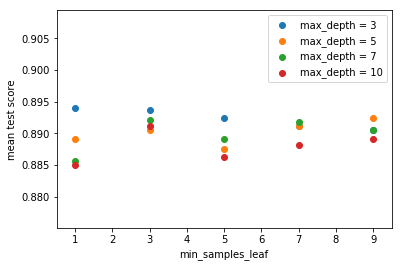

In [193]:
maxdepth3 = [0.89404, 0.89371, 0.89242, 0.89112, 0.89047]
maxdepth5 = [0.88918, 0.89047, 0.88756, 0.89112, 0.89242]
maxdepth7 = [0.88561, 0.89209, 0.88918, 0.89177, 0.89047]
maxdepth10 = [0.88496, 0.89112, 0.88626, 0.88820, 0.88918]
minsamples = [1, 3, 5, 7, 9]
plt.scatter(minsamples, maxdepth3, label='max_depth = 3')
plt.scatter(minsamples, maxdepth5, label='max_depth = 5')
plt.scatter(minsamples, maxdepth7, label='max_depth = 7')
plt.scatter(minsamples, maxdepth10, label='max_depth = 10')
plt.xlabel('min_samples_leaf')
plt.ylabel('mean test score')
plt.legend()
plt.show()

In [64]:
params = {'learning_rate': [0.05],
          'n_estimators': [130, 150, 170, 200]}
gb3 = GridSearchCV(gbc, params, n_jobs=-1, scoring='accuracy', cv=4, verbose=3)
gb3.fit(X_train, t_train)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV] learning_rate=0.05, n_estimators=130 ............................
[CV] learning_rate=0.05, n_estimators=130 ............................
[CV] learning_rate=0.05, n_estimators=130 ............................
[CV] learning_rate=0.05, n_estimators=130 ............................
[CV] ... learning_rate=0.05, n_estimators=130, score=0.891192 - 2.3min
[CV] learning_rate=0.05, n_estimators=150 ............................
[CV] ... learning_rate=0.05, n_estimators=130, score=0.881748 - 2.3min
[CV] learning_rate=0.05, n_estimators=150 ............................
[CV] ... learning_rate=0.05, n_estimators=130, score=0.904824 - 2.3min
[CV] learning_rate=0.05, n_estimators=150 ............................
[CV] ... learning_rate=0.05, n_estimators=130, score=0.894668 - 2.3min
[CV] learning_rate=0.05, n_estimators=150 ............................
[CV] ... learning_rate=0.05, n_estimators=150, score=0.880463 - 2.9min
[CV] ... learning

[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 10.2min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=50, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.05], 'n_estimators': [130, 150, 170, 200]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=3)

In [70]:
params={'max_depth': [5], 'learning_rate': [0.05], 'n_estimators': [150]}
gb4 = GridSearchCV(gbc, params, n_jobs=-1, scoring='accuracy', cv=4, verbose=3)
gb4.fit(X_train, t_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV] learning_rate=0.05, max_depth=5, n_estimators=150 ...............
[CV] learning_rate=0.05, max_depth=5, n_estimators=150 ...............
[CV] learning_rate=0.05, max_depth=5, n_estimators=150 ...............
[CV] learning_rate=0.05, max_depth=5, n_estimators=150 ...............
[CV]  learning_rate=0.05, max_depth=5, n_estimators=150, score=0.888175 - 3.1min
[CV]  learning_rate=0.05, max_depth=5, n_estimators=150, score=0.883420 - 3.1min
[CV]  learning_rate=0.05, max_depth=5, n_estimators=150, score=0.897269 - 3.1min
[CV]  learning_rate=0.05, max_depth=5, n_estimators=150, score=0.899609 - 3.1min


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  3.1min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=50, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [5], 'learning_rate': [0.05], 'n_estimators': [150]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=3)

In [190]:
gb4.best_score_

0.8920933246921582

In [72]:
pred1s = gb2.best_estimator_.predict(X_test)
util.write_predictions(pred1s, test_ids, "032.csv")

pred2s = gb3.best_estimator_.predict(X_test)
util.write_predictions(pred2s, test_ids, "033.csv")

In [91]:
# import xgboost

# params = {'max_depth': 3, 
#           'eta': 0.1, 
#           'verbosity': 2, 
#           'lambda': 1,
#           'alpha': 0,
#           'nthread': 4, 
#           'objective': 'multi:softmax',
#           'seed': 50}

from sklearn.neural_network import MLPClassifier
from sklearn.grid_search import RandomizedSearchCV

params = {'hidden_layer_sizes': [(i, j, k) for i in range(60, 410, 10) for j in range(60, 410, 10) for k in range(60, 410, 10)]}
mlpc = MLPClassifier(activation='logistic', random_state=50)
mlp = RandomizedSearchCV(mlpc, params, n_iter=50, cv=4, n_jobs=-1, verbose=3)
mlp.fit(X_train, t_train)
mlp.best_score_

Fitting 4 folds for each of 50 candidates, totalling 200 fits
[CV] hidden_layer_sizes=(190, 80, 80) ................................
[CV] hidden_layer_sizes=(190, 80, 80) ................................
[CV] hidden_layer_sizes=(190, 80, 80) ................................
[CV] hidden_layer_sizes=(190, 80, 80) ................................
[CV] ....... hidden_layer_sizes=(190, 80, 80), score=0.841969 -  35.1s
[CV] hidden_layer_sizes=(340, 100, 310) ..............................
[CV] ....... hidden_layer_sizes=(190, 80, 80), score=0.850900 -  38.7s
[CV] hidden_layer_sizes=(340, 100, 310) ..............................
[CV] ....... hidden_layer_sizes=(190, 80, 80), score=0.848761 -  39.0s
[CV] hidden_layer_sizes=(340, 100, 310) ..............................
[CV] ....... hidden_layer_sizes=(190, 80, 80), score=0.847854 -  41.6s
[CV] hidden_layer_sizes=(340, 100, 310) ..............................
[CV] ..... hidden_layer_sizes=(340, 100, 310), score=0.854356 -  31.8s
[CV] hidden_lay

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.5min


[CV] ..... hidden_layer_sizes=(270, 370, 380), score=0.860495 -  36.9s
[CV] hidden_layer_sizes=(180, 380, 230) ..............................
[CV] ..... hidden_layer_sizes=(330, 360, 400), score=0.846554 -  32.8s
[CV] hidden_layer_sizes=(180, 380, 230) ..............................
[CV] ..... hidden_layer_sizes=(330, 360, 400), score=0.866580 -  47.1s
[CV] hidden_layer_sizes=(180, 380, 230) ..............................
[CV] ..... hidden_layer_sizes=(180, 380, 230), score=0.852185 -  32.9s
[CV] hidden_layer_sizes=(180, 380, 230) ..............................
[CV] ..... hidden_layer_sizes=(330, 360, 400), score=0.867014 -  41.2s
[CV] hidden_layer_sizes=(100, 280, 400) ..............................
[CV] ..... hidden_layer_sizes=(180, 380, 230), score=0.857513 -  25.9s
[CV] hidden_layer_sizes=(100, 280, 400) ..............................
[CV] ..... hidden_layer_sizes=(180, 380, 230), score=0.846554 -  20.8s
[CV] hidden_layer_sizes=(100, 280, 400) ..............................
[CV] .

[CV] ..... hidden_layer_sizes=(290, 190, 280), score=0.859192 -  27.4s
[CV] hidden_layer_sizes=(360, 210, 160) ..............................
[CV] ..... hidden_layer_sizes=(290, 190, 280), score=0.855657 -  30.1s
[CV] hidden_layer_sizes=(360, 210, 160) ..............................
[CV] ..... hidden_layer_sizes=(360, 210, 160), score=0.848329 -  26.6s
[CV] hidden_layer_sizes=(360, 400, 180) ..............................
[CV] ..... hidden_layer_sizes=(360, 210, 160), score=0.862694 -  35.0s
[CV] hidden_layer_sizes=(360, 400, 180) ..............................
[CV] ..... hidden_layer_sizes=(360, 210, 160), score=0.849155 -  24.5s
[CV] hidden_layer_sizes=(360, 400, 180) ..............................
[CV] ..... hidden_layer_sizes=(360, 210, 160), score=0.864407 -  25.9s
[CV] hidden_layer_sizes=(360, 400, 180) ..............................
[CV] ..... hidden_layer_sizes=(360, 400, 180), score=0.834190 -  25.4s
[CV] hidden_layer_sizes=(310, 200, 390) ..............................
[CV] .

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 14.6min


[CV] ..... hidden_layer_sizes=(280, 130, 110), score=0.863990 -  27.7s
[CV] hidden_layer_sizes=(210, 360, 100) ..............................
[CV] ..... hidden_layer_sizes=(200, 240, 230), score=0.858808 -  18.9s
[CV] hidden_layer_sizes=(210, 360, 100) ..............................
[CV] ..... hidden_layer_sizes=(200, 240, 230), score=0.846154 -  17.8s
[CV] hidden_layer_sizes=(210, 360, 100) ..............................
[CV] ..... hidden_layer_sizes=(210, 360, 100), score=0.835476 -  19.8s
[CV] hidden_layer_sizes=(210, 360, 100) ..............................
[CV] ..... hidden_layer_sizes=(200, 240, 230), score=0.859558 -  23.2s
[CV] hidden_layer_sizes=(330, 310, 180) ..............................
[CV] ..... hidden_layer_sizes=(210, 360, 100), score=0.849741 -  19.2s
[CV] hidden_layer_sizes=(330, 310, 180) ..............................
[CV] ..... hidden_layer_sizes=(210, 360, 100), score=0.853977 -  16.7s
[CV] hidden_layer_sizes=(330, 310, 180) ..............................
[CV] .

[CV] ..... hidden_layer_sizes=(220, 390, 240), score=0.860495 -  24.0s
[CV] hidden_layer_sizes=(290, 80, 310) ...............................
[CV] ..... hidden_layer_sizes=(220, 390, 240), score=0.861399 -  34.0s
[CV] hidden_layer_sizes=(290, 80, 310) ...............................
[CV] ...... hidden_layer_sizes=(290, 80, 310), score=0.838046 -  27.2s
[CV] hidden_layer_sizes=(200, 340, 330) ..............................
[CV] ...... hidden_layer_sizes=(290, 80, 310), score=0.847150 -  22.2s
[CV] hidden_layer_sizes=(200, 340, 330) ..............................
[CV] ...... hidden_layer_sizes=(290, 80, 310), score=0.841352 -  22.4s
[CV] hidden_layer_sizes=(200, 340, 330) ..............................
[CV] ..... hidden_layer_sizes=(200, 340, 330), score=0.854756 -  21.2s
[CV] hidden_layer_sizes=(200, 340, 330) ..............................
[CV] ...... hidden_layer_sizes=(290, 80, 310), score=0.850065 -  24.7s
[CV] hidden_layer_sizes=(390, 110, 60) ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 23.8min finished


0.8609850939727803

In [171]:
mlp.best_params_

{'hidden_layer_sizes': (310, 230, 180)}

In [90]:
params = {'hidden_layer_sizes': [(i, j) for i in range(150, 410, 25) for j in range(150, 410, 25)]}
mlp2 = RandomizedSearchCV(mlpc, params, n_iter=10, cv=4, n_jobs=-1, verbose=3)
mlp2.fit(X_train, t_train)
mlp2.best_score_

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] hidden_layer_sizes=(275, 275) ...................................
[CV] hidden_layer_sizes=(275, 275) ...................................
[CV] hidden_layer_sizes=(275, 275) ...................................
[CV] hidden_layer_sizes=(275, 275) ...................................
[CV] .......... hidden_layer_sizes=(275, 275), score=0.862468 -  26.6s
[CV] hidden_layer_sizes=(150, 225) ...................................
[CV] .......... hidden_layer_sizes=(275, 275), score=0.887306 -  27.3s
[CV] hidden_layer_sizes=(150, 225) ...................................
[CV] .......... hidden_layer_sizes=(275, 275), score=0.863459 -  27.8s
[CV] hidden_layer_sizes=(150, 225) ...................................
[CV] .......... hidden_layer_sizes=(275, 275), score=0.883963 -  27.7s
[CV] hidden_layer_sizes=(150, 225) ...................................
[CV] .......... hidden_layer_sizes=(150, 225), score=0.862468 -  13.2s
[CV] hidden_laye

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.6min


[CV] .......... hidden_layer_sizes=(275, 400), score=0.867609 -  23.1s
[CV] hidden_layer_sizes=(225, 150) ...................................
[CV] .......... hidden_layer_sizes=(275, 400), score=0.856957 -  20.4s
[CV] hidden_layer_sizes=(225, 150) ...................................
[CV] .......... hidden_layer_sizes=(275, 400), score=0.878238 -  27.8s
[CV] hidden_layer_sizes=(225, 150) ...................................
[CV] .......... hidden_layer_sizes=(275, 400), score=0.878748 -  24.1s
[CV] hidden_layer_sizes=(225, 150) ...................................
[CV] .......... hidden_layer_sizes=(225, 150), score=0.857326 -  20.6s
[CV] hidden_layer_sizes=(400, 375) ...................................
[CV] .......... hidden_layer_sizes=(225, 150), score=0.878238 -  27.1s
[CV] hidden_layer_sizes=(400, 375) ...................................
[CV] .......... hidden_layer_sizes=(225, 150), score=0.860858 -  20.5s
[CV] hidden_layer_sizes=(400, 375) ...................................
[CV] .

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  4.2min finished


0.8749189889825016

In [89]:
mlp2.best_params_

{'hidden_layer_sizes': (175, 200)}

In [172]:
params = {'hidden_layer_sizes': [(310, 230, 180)],
          'activation': ['logistic', 'tanh', 'relu'],
          'solver': ['sgd', 'adam'],
          'learning_rate': ['constant', 'adaptive']}
mlp4 = GridSearchCV(mlpc, params, cv=8, n_jobs=-1, verbose=3)
mlp4.fit(X_train, t_train)
mlp4.best_score_

Fitting 8 folds for each of 12 candidates, totalling 96 fits
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd 
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd 
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd 
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd, score=0.664083 - 1.6min
[CV]  activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd, score=0.676020 - 1.6min
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd 
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd, score=0.683805 - 1.6min
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd, score=0.683938 - 1.7min
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd, score=0.678756 - 1.5min
[CV]  activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd, score=0.691906 - 1.5min
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=adam 
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=adam 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd, score=0.688482 - 1.5min
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=adam 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd, score=0.682415 - 1.6min
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=adam, score=0.827763 -  31.0s
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=adam, score=0.850129 -  31.0s
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=adam, score=0.877551 -  32.3s
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=adam, score=0.8

/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd, score=0.676020 - 1.5min
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd, score=0.683805 - 1.5min
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd, score=0.664083 - 1.5min
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd, score=0.683938 - 1.5min
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd, score=0.678756 - 1.6min
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd, score=0.691906 - 1.6min
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd, score=0.682415 - 1.6min
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd, score=0.688482 - 1.6min
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam 


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  7.4min


[CV]  activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam, score=0.877551 -  36.6s
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam, score=0.827763 -  35.2s
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam, score=0.850129 -  34.8s
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam, score=0.886010 -  34.8s
[CV] activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam, score=0.

/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd, score=0.827763 - 1.6min
[CV] activation=tanh, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd, score=0.834625 - 1.6min
[CV] activation=tanh, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd, score=0.865285 - 1.6min
[CV] activation=tanh, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd, score=0.867876 - 1.5min
[CV] activation=tanh, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd, score=0.843342 -  58.1s
[CV] activation=tanh, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam, score=0.882653 -  10.3s
[CV] activation=tanh, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd, score=0.874016 - 1.0min
[CV] activation=tanh, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam, score=0.827763 -  13.8s
[CV] activation=tanh, h

/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd, score=0.869110 - 1.3min
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/_base.py:91: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
/Users/michaelyue/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


[CV]  activation=tanh, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam, score=0.869452 -   7.6s
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd 
[CV]  activation=tanh, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam, score=0.863517 -   6.6s
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd, score=0.084833 -   3.0s
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/_base.py:91: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
/Users/michaelyue/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


[CV]  activation=tanh, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam, score=0.879581 -  12.6s
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd, score=0.519380 -   3.0s
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/_base.py:91: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
/Users/michaelyue/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd, score=0.038265 - 1.3min
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/_base.py:91: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
/Users/michaelyue/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd, score=0.036269 - 1.3min
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd, score=0.036554 - 1.3min
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=adam 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd, score=0.520725 - 1.3min
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=adam, score=0.831633 -  10.0s
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=adam, score=0.817481 -  11.6s
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=adam, score=0.801034 -   8.1s
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=adam, score=0.862694 -  10.6s
[CV] activation=relu,

/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/_base.py:91: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
/Users/michaelyue/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=adam, score=0.853018 -  11.9s
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd 
[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd, score=0.077121 -   9.7s
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd, score=0.036649 - 1.5min
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/_base.py:91: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
/Users/michaelyue/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=constant, solver=sgd, score=0.527559 - 1.7min
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd, score=0.038265 - 1.6min
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/_base.py:91: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
/Users/michaelyue/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd, score=0.519380 - 1.7min
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/_base.py:91: RuntimeWarning: invalid value encountered in subtract
  tmp = X - X.max(axis=1)[:, np.newaxis]
/Users/michaelyue/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd, score=0.036269 - 1.5min
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd, score=0.520725 - 1.4min
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam, score=0.831633 -  10.1s
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam, score=0.817481 -  11.2s
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam, score=0.801034 -   6.3s
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd, score=0.036554 - 1.3min
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam, score=0.847150 -  13.0s
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam, score=0.862694 -   9.5s
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam, score=0.840731 -   9.7s
[CV] activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam, score=0.845550 -   6.6s


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd, score=0.036649 - 1.3min
[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=adam, score=0.853018 -   9.4s


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=relu, hidden_layer_sizes=(310, 230, 180), learning_rate=adaptive, solver=sgd, score=0.527559 - 1.2min


[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed: 18.3min finished


0.8674659753726507

In [177]:
mlp4.grid_scores_

[mean: 0.68114, std: 0.00798, params: {'activation': 'logistic', 'hidden_layer_sizes': (310, 230, 180), 'learning_rate': 'constant', 'solver': 'sgd'},
 mean: 0.86747, std: 0.01950, params: {'activation': 'logistic', 'hidden_layer_sizes': (310, 230, 180), 'learning_rate': 'constant', 'solver': 'adam'},
 mean: 0.68114, std: 0.00798, params: {'activation': 'logistic', 'hidden_layer_sizes': (310, 230, 180), 'learning_rate': 'adaptive', 'solver': 'sgd'},
 mean: 0.86747, std: 0.01950, params: {'activation': 'logistic', 'hidden_layer_sizes': (310, 230, 180), 'learning_rate': 'adaptive', 'solver': 'adam'},
 mean: 0.85062, std: 0.01216, params: {'activation': 'tanh', 'hidden_layer_sizes': (310, 230, 180), 'learning_rate': 'constant', 'solver': 'sgd'},
 mean: 0.86261, std: 0.01661, params: {'activation': 'tanh', 'hidden_layer_sizes': (310, 230, 180), 'learning_rate': 'constant', 'solver': 'adam'},
 mean: 0.85548, std: 0.01649, params: {'activation': 'tanh', 'hidden_layer_sizes': (310, 230, 180),

In [178]:
params = {'hidden_layer_sizes': [(175, 200)],
          'activation': ['logistic', 'tanh'],
          'solver': ['sgd', 'adam'],
          'learning_rate': ['constant', 'adaptive']}
mlp5 = GridSearchCV(mlpc, params, cv=8, n_jobs=-1, verbose=3)
mlp5.fit(X_train, t_train)
mlp5.best_params_, mlp5.best_score_

Fitting 8 folds for each of 8 candidates, totalling 64 fits
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=sgd 
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=sgd 
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=sgd 
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=sgd, score=0.764858 -  41.1s
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=sgd 
[CV]  activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=sgd, score=0.782383 -  45.0s
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=sgd, score=0.785714 -  49.1s
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=sgd, score=0.773779 -  49.3s
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=sgd, score=0.782383 -  44.7s
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=adam 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=sgd, score=0.780679 -  44.3s
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=sgd, score=0.774869 -  40.7s
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=adam 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=sgd, score=0.784777 -  43.7s
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=adam, score=0.885204 -  21.3s
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=adam, score=0.893782 -  17.1s
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=adam, score=0.848329 -  23.3s
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=constant, solver=adam, score=0.868217 -  24.1s
[CV] activation=logistic, hidd

/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=sgd, score=0.785714 -  53.9s
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=sgd, score=0.773779 -  53.4s
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=sgd, score=0.764858 -  53.4s
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=sgd, score=0.782383 -  55.2s
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=sgd 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=sgd, score=0.782383 -  51.1s
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=sgd, score=0.780679 -  51.8s
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=sgd, score=0.774869 -  52.9s
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=sgd, score=0.784777 -  53.0s
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam 


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.0min


[CV]  activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam, score=0.885204 -  22.5s
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam, score=0.848329 -  23.1s
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam, score=0.893782 -  15.5s
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam, score=0.868217 -  22.5s
[CV] activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam 
[CV]  activation=logistic, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam, score=0.867876 -  16.9s
[CV] activation=tanh, hidden_

/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=sgd, score=0.808786 -  46.0s
[CV] activation=tanh, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam, score=0.890306 -  10.9s
[CV] activation=tanh, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=sgd, score=0.825065 -  43.2s
[CV] activation=tanh, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam, score=0.840617 -  14.9s
[CV] activation=tanh, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam, score=0.839793 -   7.2s
[CV] activation=tanh, hidden_layer_sizes=(175, 200), learning_rate=

/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=sgd, score=0.840314 -  43.9s
[CV] activation=tanh, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam, score=0.891192 -   8.4s
[CV] activation=tanh, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam 


/Users/michaelyue/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


[CV]  activation=tanh, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=sgd, score=0.839895 -  43.6s
[CV] activation=tanh, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam 
[CV]  activation=tanh, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam, score=0.856397 -   6.6s
[CV]  activation=tanh, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam, score=0.875648 -   8.7s
[CV]  activation=tanh, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam, score=0.879265 -   5.5s
[CV]  activation=tanh, hidden_layer_sizes=(175, 200), learning_rate=adaptive, solver=adam, score=0.869110 -   9.2s


[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:  6.9min finished


({'activation': 'logistic',
  'hidden_layer_sizes': (175, 200),
  'learning_rate': 'constant',
  'solver': 'adam'},
 0.8729747245625405)

In [180]:
params = {'hidden_layer_sizes': [(i, j, k) for i in range(50, 1110, 10) for j in range(50, 1110, 10) for k in range(50, 410, 10)]}
mlpt = MLPClassifier(activation='tanh', random_state=50)
mlp6 = RandomizedSearchCV(mlpt, params, n_iter=50, cv=4, n_jobs=-1, verbose=3)
mlp6.fit(X_train, t_train)
mlp6.best_score_

Fitting 4 folds for each of 50 candidates, totalling 200 fits
[CV] hidden_layer_sizes=(840, 1070, 150) .............................
[CV] hidden_layer_sizes=(840, 1070, 150) .............................
[CV] hidden_layer_sizes=(840, 1070, 150) .............................
[CV] hidden_layer_sizes=(840, 1070, 150) .............................
[CV] .... hidden_layer_sizes=(840, 1070, 150), score=0.849614 -  47.3s
[CV] hidden_layer_sizes=(840, 560, 360) ..............................
[CV] .... hidden_layer_sizes=(840, 1070, 150), score=0.860858 -  52.0s
[CV] hidden_layer_sizes=(840, 560, 360) ..............................
[CV] .... hidden_layer_sizes=(840, 1070, 150), score=0.870466 - 1.0min
[CV] hidden_layer_sizes=(840, 560, 360) ..............................
[CV] .... hidden_layer_sizes=(840, 1070, 150), score=0.867014 - 1.0min
[CV] hidden_layer_sizes=(840, 560, 360) ..............................
[CV] ..... hidden_layer_sizes=(840, 560, 360), score=0.841902 -  40.6s
[CV] hidden_lay

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.8min


[CV] ...... hidden_layer_sizes=(890, 350, 60), score=0.860858 -  32.5s
[CV] hidden_layer_sizes=(1050, 400, 210) .............................
[CV] ...... hidden_layer_sizes=(70, 630, 140), score=0.852332 -  11.0s
[CV] hidden_layer_sizes=(1050, 400, 210) .............................
[CV] ...... hidden_layer_sizes=(70, 630, 140), score=0.853056 -  11.6s
[CV] hidden_layer_sizes=(1050, 400, 210) .............................
[CV] ...... hidden_layer_sizes=(70, 630, 140), score=0.859192 -  10.7s
[CV] hidden_layer_sizes=(1050, 400, 210) .............................
[CV] .... hidden_layer_sizes=(1050, 400, 210), score=0.849155 -  26.0s
[CV] hidden_layer_sizes=(830, 1100, 190) .............................
[CV] .... hidden_layer_sizes=(1050, 400, 210), score=0.852185 -  40.0s
[CV] hidden_layer_sizes=(830, 1100, 190) .............................
[CV] .... hidden_layer_sizes=(1050, 400, 210), score=0.867876 -  43.4s
[CV] hidden_layer_sizes=(830, 1100, 190) .............................
[CV] .

[CV] ..... hidden_layer_sizes=(240, 690, 260), score=0.847458 -  11.1s
[CV] hidden_layer_sizes=(1040, 730, 210) .............................
[CV] ..... hidden_layer_sizes=(240, 690, 260), score=0.863990 -  28.6s
[CV] hidden_layer_sizes=(1040, 730, 210) .............................
[CV] .... hidden_layer_sizes=(1040, 730, 210), score=0.853470 -  42.2s
[CV] hidden_layer_sizes=(340, 730, 360) ..............................
[CV] .... hidden_layer_sizes=(1040, 730, 210), score=0.856218 -  56.0s
[CV] hidden_layer_sizes=(340, 730, 360) ..............................
[CV] ..... hidden_layer_sizes=(340, 730, 360), score=0.861183 -  26.0s
[CV] hidden_layer_sizes=(340, 730, 360) ..............................
[CV] .... hidden_layer_sizes=(1040, 730, 210), score=0.866060 -  58.6s
[CV] hidden_layer_sizes=(340, 730, 360) ..............................
[CV] .... hidden_layer_sizes=(1040, 730, 210), score=0.883963 -  57.2s
[CV] hidden_layer_sizes=(440, 160, 160) ..............................
[CV] .

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 19.7min


[CV] ...... hidden_layer_sizes=(790, 60, 110), score=0.853470 -  21.0s
[CV] hidden_layer_sizes=(560, 450, 90) ...............................
[CV] ...... hidden_layer_sizes=(790, 60, 110), score=0.873057 -  24.6s
[CV] hidden_layer_sizes=(560, 450, 90) ...............................
[CV] ...... hidden_layer_sizes=(790, 60, 110), score=0.864759 -  19.7s
[CV] hidden_layer_sizes=(560, 450, 90) ...............................
[CV] ...... hidden_layer_sizes=(790, 60, 110), score=0.860495 -  20.6s
[CV] hidden_layer_sizes=(560, 450, 90) ...............................
[CV] ...... hidden_layer_sizes=(560, 450, 90), score=0.839332 -  18.3s
[CV] hidden_layer_sizes=(190, 1090, 300) .............................
[CV] ...... hidden_layer_sizes=(560, 450, 90), score=0.871762 -  18.3s
[CV] hidden_layer_sizes=(190, 1090, 300) .............................
[CV] ...... hidden_layer_sizes=(560, 450, 90), score=0.868318 -  15.1s
[CV] hidden_layer_sizes=(190, 1090, 300) .............................
[CV] .

[CV] ...... hidden_layer_sizes=(340, 380, 80), score=0.853056 -  10.4s
[CV] hidden_layer_sizes=(70, 110, 380) ...............................
[CV] ...... hidden_layer_sizes=(70, 110, 380), score=0.855657 -   3.8s
[CV] hidden_layer_sizes=(70, 110, 380) ...............................
[CV] ...... hidden_layer_sizes=(70, 110, 380), score=0.849614 -   5.5s
[CV] hidden_layer_sizes=(1070, 1070, 180) ............................
[CV] ...... hidden_layer_sizes=(70, 110, 380), score=0.865285 -   6.0s
[CV] hidden_layer_sizes=(1070, 1070, 180) ............................
[CV] ...... hidden_layer_sizes=(340, 380, 80), score=0.863103 -   9.6s
[CV] hidden_layer_sizes=(1070, 1070, 180) ............................
[CV] ...... hidden_layer_sizes=(70, 110, 380), score=0.847458 -   8.5s
[CV] hidden_layer_sizes=(1070, 1070, 180) ............................
[CV] ... hidden_layer_sizes=(1070, 1070, 180), score=0.852185 -  35.3s
[CV] hidden_layer_sizes=(290, 1030, 390) .............................
[CV] .

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 26.9min finished


0.8694102397926118

In [182]:
mlp6.grid_scores_

[mean: 0.86196, std: 0.00793, params: {'hidden_layer_sizes': (840, 1070, 150)},
 mean: 0.85677, std: 0.00986, params: {'hidden_layer_sizes': (840, 560, 360)},
 mean: 0.86228, std: 0.00895, params: {'hidden_layer_sizes': (990, 70, 230)},
 mean: 0.86682, std: 0.00831, params: {'hidden_layer_sizes': (930, 790, 400)},
 mean: 0.86228, std: 0.00758, params: {'hidden_layer_sizes': (240, 920, 210)},
 mean: 0.85774, std: 0.01291, params: {'hidden_layer_sizes': (890, 350, 60)},
 mean: 0.84932, std: 0.00987, params: {'hidden_layer_sizes': (70, 630, 140)},
 mean: 0.85807, std: 0.00767, params: {'hidden_layer_sizes': (1050, 400, 210)},
 mean: 0.86520, std: 0.01196, params: {'hidden_layer_sizes': (830, 1100, 190)},
 mean: 0.85904, std: 0.01301, params: {'hidden_layer_sizes': (550, 610, 140)},
 mean: 0.86617, std: 0.00925, params: {'hidden_layer_sizes': (350, 480, 160)},
 mean: 0.86844, std: 0.01320, params: {'hidden_layer_sizes': (730, 480, 80)},
 mean: 0.86261, std: 0.01232, params: {'hidden_layer_

In [124]:
mlp3.grid_scores_

[mean: 0.87297, std: 0.01373, params: {'activation': 'logistic', 'hidden_layer_sizes': (175, 200)},
 mean: 0.74303, std: 0.03006, params: {'activation': 'identity', 'hidden_layer_sizes': (175, 200)},
 mean: 0.86779, std: 0.01905, params: {'activation': 'tanh', 'hidden_layer_sizes': (175, 200)},
 mean: 0.81205, std: 0.02837, params: {'activation': 'relu', 'hidden_layer_sizes': (175, 200)}]

In [125]:
params = {'n_estimators': [50, 75, 100, 150, 200, 250, 300, 400, 500]}
rf10 = RandomForestClassifier(random_state=50)
gb10 = GradientBoostingClassifier(random_state=50)
ab10 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), random_state=50)
b10 = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), random_state=50)

c1 = GridSearchCV(rf10, params, cv=8, n_jobs=-1, verbose=3)
c1.fit(X_train, t_train)

Fitting 8 folds for each of 9 candidates, totalling 72 fits
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] ........................ n_estimators=50, score=0.871465 -   1.8s
[CV] ........................ n_estimators=50, score=0.896373 -   1.8s
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] ........................ n_estimators=50, score=0.881137 -   1.9s
[CV] ........................ n_estimators=50, score=0.908163 -   2.0s
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] ........................ n_estimators=50, score=0.906005 -   1.9s
[CV] n_estimators

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   17.5s


[CV] ....................... n_estimators=150, score=0.903061 -   4.9s
[CV] n_estimators=150 ................................................
[CV] ....................... n_estimators=150, score=0.874036 -   5.0s
[CV] n_estimators=150 ................................................
[CV] ....................... n_estimators=150, score=0.893782 -   4.8s
[CV] n_estimators=150 ................................................
[CV] ....................... n_estimators=150, score=0.881137 -   5.0s
[CV] n_estimators=150 ................................................
[CV] ....................... n_estimators=150, score=0.900783 -   5.2s
[CV] n_estimators=200 ................................................
[CV] ....................... n_estimators=150, score=0.909326 -   5.4s
[CV] n_estimators=200 ................................................
[CV] ....................... n_estimators=150, score=0.900524 -   5.4s
[CV] n_estimators=200 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  2.4min finished


GridSearchCV(cv=8, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=50, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 75, 100, 150, 200, 250, 300, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=3)

In [126]:
c2 = GridSearchCV(gb10, params, cv=8, n_jobs=-1, verbose=3)
c2.fit(X_train, t_train)

Fitting 8 folds for each of 9 candidates, totalling 72 fits
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] ........................ n_estimators=50, score=0.903061 -  45.4s
[CV] n_estimators=50 .................................................
[CV] ........................ n_estimators=50, score=0.896373 -  45.6s
[CV] n_estimators=50 .................................................
[CV] ........................ n_estimators=50, score=0.888889 -  45.7s
[CV] n_estimators=50 .................................................
[CV] ........................ n_estimators=50, score=0.871465 -  45.9s
[CV] n_estimators=50 .................................................
[CV] ........................ n_estimators=50, score=0.908616 -  46.9s
[CV] ............

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  6.7min


[CV] n_estimators=150 ................................................
[CV] ....................... n_estimators=150, score=0.868895 - 2.3min
[CV] n_estimators=150 ................................................
[CV] ....................... n_estimators=150, score=0.908163 - 2.3min
[CV] n_estimators=150 ................................................
[CV] ....................... n_estimators=150, score=0.883721 - 2.3min
[CV] n_estimators=150 ................................................
[CV] ....................... n_estimators=150, score=0.901554 - 2.3min
[CV] n_estimators=150 ................................................
[CV] ....................... n_estimators=150, score=0.903394 - 1.8min
[CV] n_estimators=200 ................................................
[CV] ....................... n_estimators=150, score=0.901554 - 1.8min
[CV] n_estimators=200 ................................................
[CV] ....................... n_estimators=150, score=0.905759 - 1.8min
[CV] n

[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 47.2min finished


GridSearchCV(cv=8, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=50, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 75, 100, 150, 200, 250, 300, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=3)

In [127]:
c3 = GridSearchCV(ab10, params, cv=8, n_jobs=-1, verbose=3)
c3.fit(X_train, t_train)

Fitting 8 folds for each of 9 candidates, totalling 72 fits
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] ........................ n_estimators=50, score=0.730077 -   3.2s
[CV] ........................ n_estimators=50, score=0.471503 -   3.1s
[CV] n_estimators=50 .................................................
[CV] ........................ n_estimators=50, score=0.806122 -   3.3s
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] ........................ n_estimators=50, score=0.790698 -   3.3s
[CV] n_estimators=50 .................................................
[CV] ........................ n_estimators=50, score=0.798956 -   3.2s
[CV] n_estimators

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   29.8s


[CV] ....................... n_estimators=150, score=0.806122 -   9.3s
[CV] n_estimators=150 ................................................
[CV] ....................... n_estimators=150, score=0.730077 -   9.4s
[CV] n_estimators=150 ................................................
[CV] ....................... n_estimators=150, score=0.617571 -   9.6s
[CV] n_estimators=150 ................................................
[CV] ....................... n_estimators=150, score=0.707254 -   9.5s
[CV] n_estimators=150 ................................................
[CV] ....................... n_estimators=150, score=0.829016 -   9.3s
[CV] n_estimators=200 ................................................
[CV] ....................... n_estimators=150, score=0.454308 -   9.6s
[CV] n_estimators=200 ................................................
[CV] ....................... n_estimators=150, score=0.636126 -   9.3s
[CV] n_estimators=200 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  4.4min finished


GridSearchCV(cv=8, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=50),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 75, 100, 150, 200, 250, 300, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=3)

In [129]:
c4 = GridSearchCV(b10, params, cv=8, n_jobs=-1, verbose=3)
c4.fit(X_train, t_train)

Fitting 8 folds for each of 9 candidates, totalling 72 fits
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] ........................ n_estimators=50, score=0.803571 -   3.0s
[CV] ........................ n_estimators=50, score=0.796915 -   3.0s
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] ........................ n_estimators=50, score=0.808786 -   3.1s
[CV] n_estimators=50 .................................................
[CV] ........................ n_estimators=50, score=0.808290 -   3.1s
[CV] n_estimators=50 .................................................
[CV] ........................ n_estimators=50, score=0.809399 -   3.2s
[CV] n_estimators

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   27.7s


[CV] ....................... n_estimators=150, score=0.808786 -   8.7s
[CV] n_estimators=150 ................................................
[CV] ....................... n_estimators=150, score=0.803571 -   8.9s
[CV] n_estimators=150 ................................................
[CV] ....................... n_estimators=150, score=0.796915 -   8.9s
[CV] n_estimators=150 ................................................
[CV] ....................... n_estimators=150, score=0.808290 -   8.8s
[CV] n_estimators=150 ................................................
[CV] ....................... n_estimators=150, score=0.808290 -   8.8s
[CV] n_estimators=200 ................................................
[CV] ....................... n_estimators=150, score=0.796345 -   8.8s
[CV] n_estimators=200 ................................................
[CV] ....................... n_estimators=150, score=0.808901 -   8.8s
[CV] n_estimators=200 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  4.1min finished


GridSearchCV(cv=8, error_score='raise',
       estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min..., n_estimators=10, n_jobs=1, oob_score=False,
         random_state=50, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 75, 100, 150, 200, 250, 300, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=3)

In [158]:
newparams = {'n_estimators': [5, 10, 25]}
c5 = GridSearchCV(rf10, newparams, cv=8, n_jobs=-1, verbose=3)
c6 = GridSearchCV(gb10, newparams, cv=8, n_jobs=-1, verbose=3)
c7 = GridSearchCV(ab10, newparams, cv=8, n_jobs=-1, verbose=3)
c8 = GridSearchCV(b10, newparams, cv=8, n_jobs=-1, verbose=3)
c5.fit(X_train, t_train)
c6.fit(X_train, t_train)
c7.fit(X_train, t_train)
c8.fit(X_train, t_train)

Fitting 8 folds for each of 3 candidates, totalling 24 fits
[CV] n_estimators=5 ..................................................
[CV] n_estimators=5 ..................................................
[CV] ......................... n_estimators=5, score=0.885204 -   0.2s
[CV] n_estimators=5 ..................................................
[CV] ......................... n_estimators=5, score=0.858612 -   0.2s
[CV] n_estimators=5 ..................................................
[CV] n_estimators=5 ..................................................
[CV] n_estimators=5 ..................................................
[CV] ......................... n_estimators=5, score=0.873385 -   0.2s
[CV] ......................... n_estimators=5, score=0.898964 -   0.2s
[CV] n_estimators=5 ..................................................
[CV] ......................... n_estimators=5, score=0.901554 -   0.2s
[CV] n_estimators=5 ..................................................
[CV] n_estimators

[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    3.8s finished


Fitting 8 folds for each of 3 candidates, totalling 24 fits
[CV] n_estimators=5 ..................................................
[CV] n_estimators=5 ..................................................
[CV] n_estimators=5 ..................................................
[CV] n_estimators=5 ..................................................
[CV] ......................... n_estimators=5, score=0.868217 -   5.8s
[CV] ......................... n_estimators=5, score=0.880102 -   5.9s
[CV] ......................... n_estimators=5, score=0.886010 -   5.8s
[CV] n_estimators=5 ..................................................
[CV] n_estimators=5 ..................................................
[CV] n_estimators=5 ..................................................
[CV] ......................... n_estimators=5, score=0.861183 -   5.9s
[CV] n_estimators=5 ..................................................
[CV] ......................... n_estimators=5, score=0.869452 -   5.0s
[CV] n_estimators

[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.3min finished


Fitting 8 folds for each of 3 candidates, totalling 24 fits
[CV] n_estimators=5 ..................................................
[CV] n_estimators=5 ..................................................
[CV] n_estimators=5 ..................................................
[CV] n_estimators=5 ..................................................
[CV] ......................... n_estimators=5, score=0.645408 -   0.7s
[CV] ......................... n_estimators=5, score=0.627249 -   0.7s
[CV] n_estimators=5 ..................................................
[CV] ......................... n_estimators=5, score=0.602067 -   0.6s
[CV] n_estimators=5 ..................................................
[CV] n_estimators=5 ..................................................
[CV] ......................... n_estimators=5, score=0.624352 -   0.6s
[CV] n_estimators=5 ..................................................
[CV] ......................... n_estimators=5, score=0.605744 -   0.6s
[CV] ............

[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    9.0s finished


Fitting 8 folds for each of 3 candidates, totalling 24 fits
[CV] n_estimators=5 ..................................................
[CV] n_estimators=5 ..................................................
[CV] n_estimators=5 ..................................................
[CV] n_estimators=5 ..................................................
[CV] ......................... n_estimators=5, score=0.801020 -   0.5s
[CV] n_estimators=5 ..................................................
[CV] ......................... n_estimators=5, score=0.808786 -   0.5s
[CV] ......................... n_estimators=5, score=0.786632 -   0.5s
[CV] ......................... n_estimators=5, score=0.808290 -   0.5s
[CV] n_estimators=5 ..................................................
[CV] n_estimators=5 ..................................................
[CV] n_estimators=5 ..................................................
[CV] ......................... n_estimators=5, score=0.800518 -   0.5s
[CV] n_estimators

[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    6.9s finished


GridSearchCV(cv=8, error_score='raise',
       estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min..., n_estimators=10, n_jobs=1, oob_score=False,
         random_state=50, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 25]}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=3)

In [166]:
abparams = {'n_estimators': [5, 10, 25, 50, 75, 100, 150, 200, 250, 300, 400, 500]}
c9 = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), random_state=28), abparams, cv=8, n_jobs=-1, verbose=3)
c9.fit(X_train, t_train)

Fitting 8 folds for each of 12 candidates, totalling 96 fits
[CV] n_estimators=5 ..................................................
[CV] n_estimators=5 ..................................................
[CV] n_estimators=5 ..................................................
[CV] n_estimators=5 ..................................................
[CV] ......................... n_estimators=5, score=0.645408 -   0.4s
[CV] n_estimators=5 ..................................................
[CV] ......................... n_estimators=5, score=0.624352 -   0.5s
[CV] n_estimators=5 ..................................................
[CV] ......................... n_estimators=5, score=0.602067 -   0.6s
[CV] ......................... n_estimators=5, score=0.627249 -   0.6s
[CV] n_estimators=5 ..................................................
[CV] n_estimators=5 ..................................................
[CV] ......................... n_estimators=5, score=0.790155 -   0.6s
[CV] n_estimator

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.1s


[CV] ........................ n_estimators=50, score=0.806122 -   4.8s
[CV] n_estimators=50 .................................................
[CV] ........................ n_estimators=50, score=0.730077 -   4.8s
[CV] n_estimators=50 .................................................
[CV] ........................ n_estimators=50, score=0.468912 -   4.7s
[CV] ........................ n_estimators=50, score=0.806202 -   4.8s
[CV] n_estimators=50 .................................................
[CV] n_estimators=50 .................................................
[CV] ........................ n_estimators=50, score=0.722798 -   5.5s
[CV] ........................ n_estimators=50, score=0.798956 -   5.5s
[CV] n_estimators=75 .................................................
[CV] n_estimators=75 .................................................
[CV] ........................ n_estimators=50, score=0.643979 -   5.4s
[CV] n_estimators=75 .................................................
[CV] .

[CV] ....................... n_estimators=400, score=0.803618 -  29.3s
[CV] n_estimators=400 ................................................
[CV] ....................... n_estimators=400, score=0.751295 -  29.3s
[CV] n_estimators=400 ................................................
[CV] ....................... n_estimators=400, score=0.477807 -  33.0s
[CV] n_estimators=500 ................................................
[CV] ....................... n_estimators=400, score=0.668394 -  33.5s
[CV] n_estimators=500 ................................................
[CV] ....................... n_estimators=400, score=0.740838 -  33.3s
[CV] n_estimators=500 ................................................
[CV] ....................... n_estimators=400, score=0.826772 -  33.7s
[CV] n_estimators=500 ................................................
[CV] ....................... n_estimators=500, score=0.806122 -  32.7s
[CV] n_estimators=500 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  5.5min finished


GridSearchCV(cv=8, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=28),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 25, 50, 75, 100, 150, 200, 250, 300, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=3)

In [183]:
abparams = {'n_estimators': [5, 10, 25, 50, 75, 100, 150, 200, 250, 300, 400, 500]}
c10 = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), loss='exponential', random_state=28), abparams, cv=8, n_jobs=-1, verbose=3)
c10.fit(X_train, t_train)

TypeError: __init__() got an unexpected keyword argument 'loss'

In [167]:
abx = [i[1] for i in c7.grid_scores_] + [i[1] for i in c3.grid_scores_]
aby = [i[1] for i in c9.grid_scores_]
abx, aby

([0.6688269604666235,
  0.7232663642255347,
  0.6668826960466624,
  0.7271548930654569,
  0.6811406351263772,
  0.6746597537265068,
  0.6928062216461439,
  0.7644199611147116,
  0.7861309138042774,
  0.7637718729747246,
  0.7705767984445885,
  0.7631237848347375],
 [0.6688269604666235,
  0.7232663642255347,
  0.6607258587167855,
  0.7047958522359041,
  0.712248865845755,
  0.7086843810758263,
  0.6600777705767984,
  0.6924821775761504,
  0.6885936487362281,
  0.7018794556059624,
  0.7258587167854829,
  0.7333117303953338])

In [150]:
import matplotlib.pyplot as plt

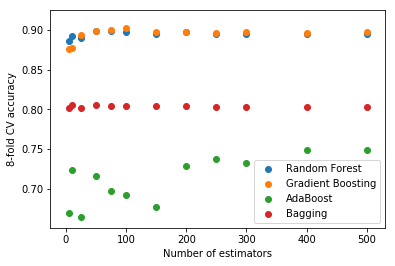

In [170]:
plt.scatter(abparams['n_estimators'], [i[1] for i in c5.grid_scores_] + [i[1] for i in c1.grid_scores_], label='Random Forest')
plt.scatter(abparams['n_estimators'], [i[1] for i in c6.grid_scores_] + [i[1] for i in c2.grid_scores_], label='Gradient Boosting')
plt.scatter(abparams['n_estimators'], [(abx[i] + aby[i])/2 for i in range(len(abx))], label='AdaBoost')
plt.scatter(abparams['n_estimators'], [i[1] for i in c8.grid_scores_] + [i[1] for i in c4.grid_scores_], label='Bagging')
plt.xlabel('Number of estimators')
plt.ylabel('8-fold CV accuracy')
plt.legend()
plt.show()